## KORA_S3S4 Data Analysis - Minimum Model - Baseline

In [18]:
import math 
import numpy as np
import pandas as pd
import os
import nbimporter
import DiagnosticPlots
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.core.debugger import set_trace
import statsmodels.api as sts
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 
## Loading the data and data splitting
### 

In [2]:
data_path = '../../Data/KORA_S3_S4/KORA_Noise_noMissing_median.csv'
KORA_Noise_noMissing = pd.read_csv(data_path)

In [23]:
# Covariates

X = KORA_Noise_noMissing.drop(['hyper_p', 'bp_diast', 'bp_syst'], axis = 1)
X_mini = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]

# noise cut-off
X_mini_test = X_mini['lden_org']
X_mini_test[X_mini_test<=40] = 40
X_mini['lden_org'] = X_mini_test

Data_numeric = KORA_Noise_noMissing[['age', 'bmi', 'lden_org', 'bp_syst']]
Data_categoric = KORA_Noise_noMissing[['sex', 'smoking']]
Data = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org', 'bp_syst']]
print('Data description \n')
print('Sex: Female = 0, Male = 1 \nSmoking: Current = 1, Ex-smoker = 2, Never-smoker =3 \n ')

X_mini.describe()

Data description 

Sex: Female = 0, Male = 1 
Smoking: Current = 1, Ex-smoker = 2, Never-smoker =3 
 


,sex,age,bmi,smoking,lden_org
count,9116.000000,9116.000000,9116.000000,9116.000000,9116.000000
mean,0.492979,49.555836,27.115082,2.169263,54.750581
std,0.499978,14.033439,4.594119,0.810235,6.498166
min,0.000000,24.000000,15.840000,1.000000,40.000000
25%,0.000000,37.000000,23.940000,1.000000,50.600000
50%,0.000000,50.000000,26.580000,2.000000,53.900000
75%,1.000000,61.000000,29.630000,3.000000,58.500000
max,1.000000,75.000000,56.930000,3.000000,77.500000


In [24]:
Data_categoric['smoking']= Data_categoric['smoking'].map({1.0:'Current', 2.0:'Ex_smoker', 3.0:'Never_smoker'})
Data_categoric['sex']= Data_categoric['sex'].map({0.0:'female', 1.0:'male'})
print(Data_categoric.dtypes)
Data_categoric.head()

sex        object
smoking    object
dtype: object


,sex,smoking
0,female,Ex_smoker
1,male,Ex_smoker
2,male,Never_smoker
3,female,Current
4,female,Ex_smoker


In [25]:
Data_numeric_scaled = pd.DataFrame(scale(Data_numeric), index=Data_numeric.index,
                           columns=Data_numeric.columns)
Data_numeric.head()
Data_numeric_scaled.head()

,age,bmi,lden_org,bp_syst
0,-1.322331,-1.779564,-2.083140,-1.256215
1,-0.680971,0.005424,0.072704,0.637412
2,0.673013,0.702005,0.072704,1.712172
3,0.886799,-1.666370,-1.202584,-1.102678
4,0.886799,0.900095,-0.534576,-0.897961


In [26]:
Data = pd.concat([Data_numeric, Data_categoric], axis= 1)
Data_scaled = pd.concat([Data_numeric_scaled, Data_categoric], axis= 1)
print(Data.head())
print(Data_scaled.head())

    age    bmi  lden_org  bp_syst     sex       smoking
0  31.0  18.94      41.0    106.0  female     Ex_smoker
1  40.0  27.14      55.2    143.0    male     Ex_smoker
2  59.0  30.34      55.2    164.0    male  Never_smoker
3  62.0  19.46      46.8    109.0  female       Current
4  62.0  31.25      51.2    113.0  female     Ex_smoker
        age       bmi  lden_org   bp_syst     sex       smoking
0 -1.322331 -1.779564 -2.083140 -1.256215  female     Ex_smoker
1 -0.680971  0.005424  0.072704  0.637412    male     Ex_smoker
2  0.673013  0.702005  0.072704  1.712172    male  Never_smoker
3  0.886799 -1.666370 -1.202584 -1.102678  female       Current
4  0.886799  0.900095 -0.534576 -0.897961  female     Ex_smoker


In [27]:
Data = pd.get_dummies(data=Data, drop_first=True)
print(Data.head())

Data_scaled = pd.get_dummies(data=Data_scaled, drop_first=True)
print(Data_scaled.head())

    age    bmi  lden_org  bp_syst  sex_male  smoking_Ex_smoker  \
0  31.0  18.94      41.0    106.0         0                  1   
1  40.0  27.14      55.2    143.0         1                  1   
2  59.0  30.34      55.2    164.0         1                  0   
3  62.0  19.46      46.8    109.0         0                  0   
4  62.0  31.25      51.2    113.0         0                  1   

   smoking_Never_smoker  
0                     0  
1                     0  
2                     1  
3                     0  
4                     0  
        age       bmi  lden_org   bp_syst  sex_male  smoking_Ex_smoker  \
0 -1.322331 -1.779564 -2.083140 -1.256215         0                  1   
1 -0.680971  0.005424  0.072704  0.637412         1                  1   
2  0.673013  0.702005  0.072704  1.712172         1                  0   
3  0.886799 -1.666370 -1.202584 -1.102678         0                  0   
4  0.886799  0.900095 -0.534576 -0.897961         0                  1   

  

In [28]:
# Output

Y_hyper = KORA_Noise_noMissing['hyper_p'].astype(int)
Y_SBP = KORA_Noise_noMissing['bp_syst']
Y_DBP = KORA_Noise_noMissing['bp_diast']


In [29]:
# make the formular
variables = Data.columns.drop('bp_syst')
formula = ' + '.join(variables)
formula = 'bp_syst ~ ' + formula
print(formula)

bp_syst ~ age + bmi + lden_org + sex_male + smoking_Ex_smoker + smoking_Never_smoker


In [30]:

# mod = smf.quantreg(formula, Data)
mod = smf.ols(formula, Data)
res = mod.fit(q=.5)
print(res.summary())
file = open('regression_estimates.txt', 'w')
file.write(str(res.summary()))
file.close()

                            OLS Regression Results                            
Dep. Variable:                bp_syst   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     550.7
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:32:03   Log-Likelihood:                -38621.
No. Observations:                9116   AIC:                         7.726e+04
Df Residuals:                    9109   BIC:                         7.731e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               77.7206 

In [31]:
unit = 1
res.change = (np.exp(res.params * unit)-1) * 100
res.change.name='Change'

res.change_LL = (np.exp((res.params - 1.96 * res.bse)*unit)-1)*100
res.change_LL.name='Change_LL'

res.change_UL = (np.exp((res.params + 1.96 * res.bse)*unit)-1)*100
res.change_UL.name='Change_UL'

summary = pd.concat([res.change, res.change_LL, res.change_UL, res.params, res.bse, res.tvalues, res.pvalues],
                    names=['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'], axis = 1)
summary.to_excel('output/Linear Regression/LR_results_python.xlsx',
                 header= ['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'])
print(summary)

                            Change     Change_LL     Change_UL          0  \
Intercept             5.670741e+35  1.587041e+34  2.026243e+37  77.720628   
age                   6.866348e+01  6.427934e+01  7.316462e+01   0.522735   
bmi                   1.105674e+02  9.458580e+01  1.278616e+02   0.744636   
lden_org              3.982818e+00 -1.318424e+00  9.568847e+00   0.039055   
sex_male              3.876085e+05  1.898410e+05  7.912925e+05   8.262839   
smoking_Ex_smoker    -3.300761e+01 -7.372549e+01  7.081124e+01  -0.400591   
smoking_Never_smoker  3.526520e+02  8.487868e+01  1.008261e+03   1.509953   

                             1          2              3  
Intercept             1.824507  42.598154   0.000000e+00  
age                   0.013437  38.901643  2.162105e-306  
bmi                   0.040272  18.490283   5.760600e-75  
lden_org              0.026698   1.462881   1.435346e-01  
sex_male              0.364051  22.696914  5.526182e-111  
smoking_Ex_smoker     0.47754

In [32]:
mod_scaled = smf.ols(formula, Data_scaled)
res_scaled = mod.fit(q=.5)
print(res.summary())
file = open('regression_estimates_scaled.txt', 'w')
file.write(str(res_scaled.summary()))
file.close()

                            OLS Regression Results                            
Dep. Variable:                bp_syst   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     550.7
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:32:05   Log-Likelihood:                -38621.
No. Observations:                9116   AIC:                         7.726e+04
Df Residuals:                    9109   BIC:                         7.731e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               77.7206 

In [33]:
unit = 1

#           percentage change for the original outcome = (est*incr/mean)*100 
res_scaled.change = ((res_scaled.params * unit) / mean(X_)) * 100
res_scaled.change.name='Change'

res_scaled.change_LL = (np.exp((res_scaled.params - 1.96 * res_scaled.bse)*unit)-1)*100
res_scaled.change_LL.name='Change_LL'

res_scaled.change_UL = (np.exp((res_scaled.params + 1.96 * res_scaled.bse)*unit)-1)*100
res_scaled.change_UL.name='Change_UL'



#            percentage change for the log transformation of the outcome

# res_scaled.change = (np.exp(res_scaled.params * unit)-1) * 100
# res_scaled.change.name='Change'

# res_scaled.change_LL = (np.exp((res_scaled.params - 1.96 * res_scaled.bse)*unit)-1)*100
# res_scaled.change_LL.name='Change_LL'

# res_scaled.change_UL = (np.exp((res_scaled.params + 1.96 * res_scaled.bse)*unit)-1)*100
# res_scaled.change_UL.name='Change_UL'

summary_scaled = pd.concat([res_scaled.change, res_scaled.change_LL, res_scaled.change_UL, res_scaled.params,
                     res_scaled.bse, res_scaled.tvalues, res.pvalues],
                    names=['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'], axis = 1)

summary_scaled.to_excel('output/Linear Regression/LR_scaled_results_python.xlsx',
                 header= ['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'])
print(summary_scaled)

NameError: name 'mean' is not defined

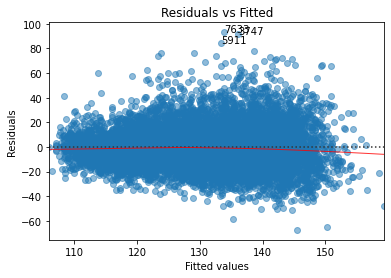

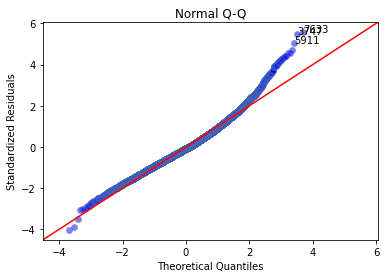

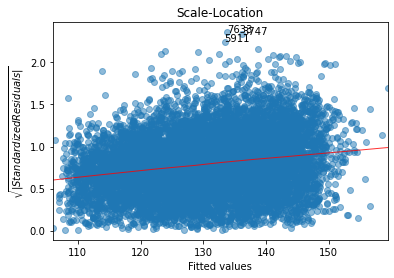

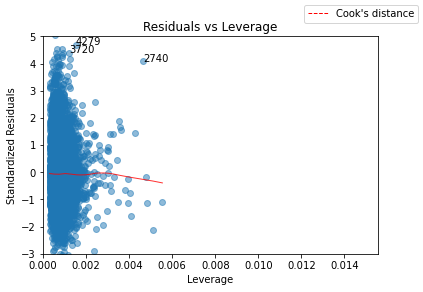

In [34]:
output = Data['bp_syst']
Covariates = Data.drop(['bp_syst'], axis = 1)
DiagnosticPlots.diagnostic_plots(Covariates, output)

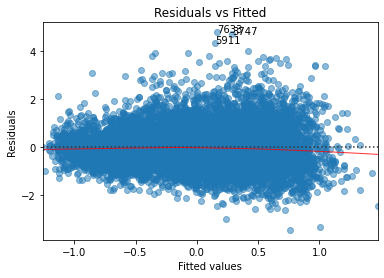

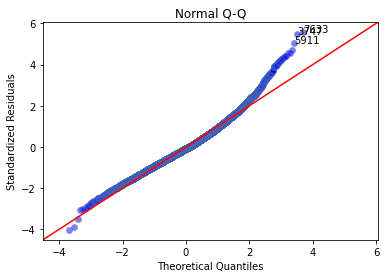

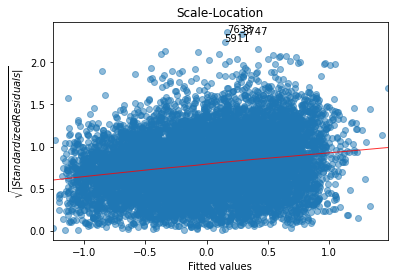

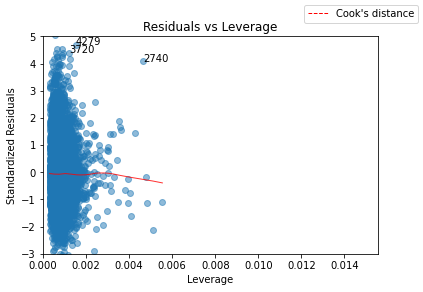

In [75]:
output_scaled = Data_scaled['bp_syst']
Covariates_scaled = Data_scaled.drop(['bp_syst'], axis = 1)
DiagnosticPlots.diagnostic_plots(Covariates_scaled, output_scaled)

## Prediction

### Train - test data split

In [35]:
# original data
X_train, X_test, y_train, y_test = train_test_split(Data.drop(['bp_syst'], axis = 1),
                                Data['bp_syst'], test_size=0.2, random_state = 10)

# scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    Data_scaled.drop(['bp_syst'], axis = 1), Data_scaled['bp_syst'], test_size=0.2, random_state = 10)


In [36]:
# make the formular
variables = train_Data.columns.drop('bp_syst')
formula = 'bp_syst ~ ' + ' + '.join(variables)
print(formula)

NameError: name 'train_Data' is not defined

In [37]:
# Original data
LR_model = sts.OLS(y_train, X_train)
res_pred = LR_model.fit()
print(res_pred.summary())

                                 OLS Regression Results                                
Dep. Variable:                bp_syst   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          6.234e+04
Date:                Thu, 15 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:34:46   Log-Likelihood:                         -31521.
No. Observations:                7292   AIC:                                  6.305e+04
Df Residuals:                    7286   BIC:                                  6.310e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [38]:
y_pred = res_pred.predict(X_test)
print('Mean squared error (MSE) : %.2f' % mean_squared_error(y_test, y_pred))
print('Mean absolute error (MAE) : %.2f' % mean_absolute_error(y_test, y_pred))
print('R^2: %.2f' % r2_score(y_test, y_pred))

Mean squared error (MSE) : 348.77
Mean absolute error (MAE) : 14.49
R^2: 0.13


In [39]:
# scaled data
LR_model_scaled = sts.OLS(y_train_scaled, X_train_scaled)
res_pred_scaled = LR_model_scaled.fit()
print(res_pred_scaled.summary())

                                 OLS Regression Results                                
Dep. Variable:                bp_syst   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.255
Method:                 Least Squares   F-statistic:                              416.7
Date:                Thu, 15 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:34:48   Log-Likelihood:                         -9221.3
No. Observations:                7292   AIC:                                  1.845e+04
Df Residuals:                    7286   BIC:                                  1.850e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [40]:
y_pred_scaled = res_pred.predict(X_test_scaled)
print('Mean squared error (MSE) : %.2f' % mean_squared_error(y_test_scaled, y_pred_scaled))
print('Mean absolute error (MAE) : %.2f' % mean_absolute_error(y_test_scaled, y_pred_scaled))
print('R^2: %.2f' % r2_score(y_test_scaled, y_pred_scaled))

Mean squared error (MSE) : 62.08
Mean absolute error (MAE) : 6.54
R^2: -57.88
